In [1]:

import numpy as np
import jax
import jax.numpy as jnp

from scoobpsf.imshows import *
import scoobpsf.jax_scoob as jscoob
import scoobpsf.jax_dm as jdm

from scoobpsf.jax_scoob import ensure_np_array

from jax.scipy.optimize import minimize

from importlib import reload



Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


In [2]:
reload(jscoob)
model = jscoob.SCOOB(npix=200, oversample=10, npsf=200, dm_fill_factor=0.9)
LS = model.pupil_grid[0] < model.pupil_diam.to_value(u.m)/2 * 0.9
model.LYOT = LS

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
2023-09-22 09:34:20.991086: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-09-22 09:34:21.253912: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-09-22 09:34:21.818800: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-09-22 09:34:22.016936: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-09-22 09:34:22.079163: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


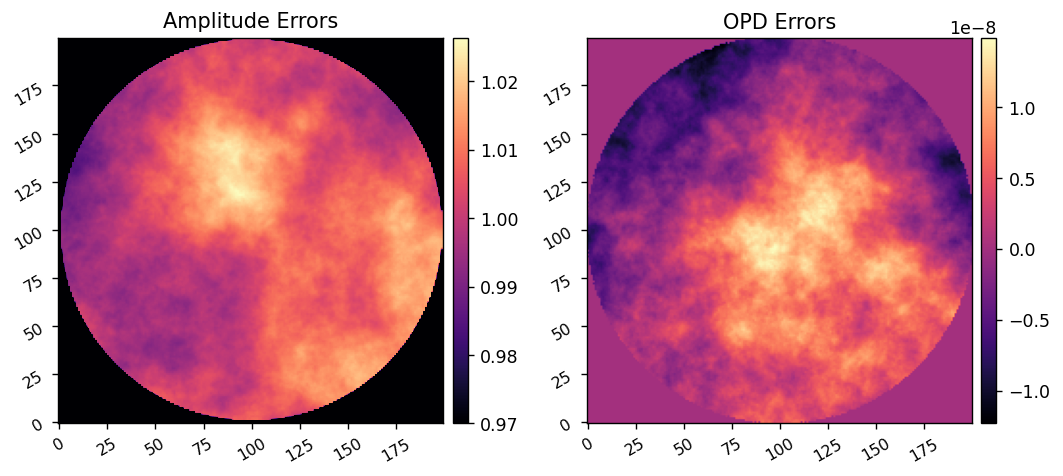

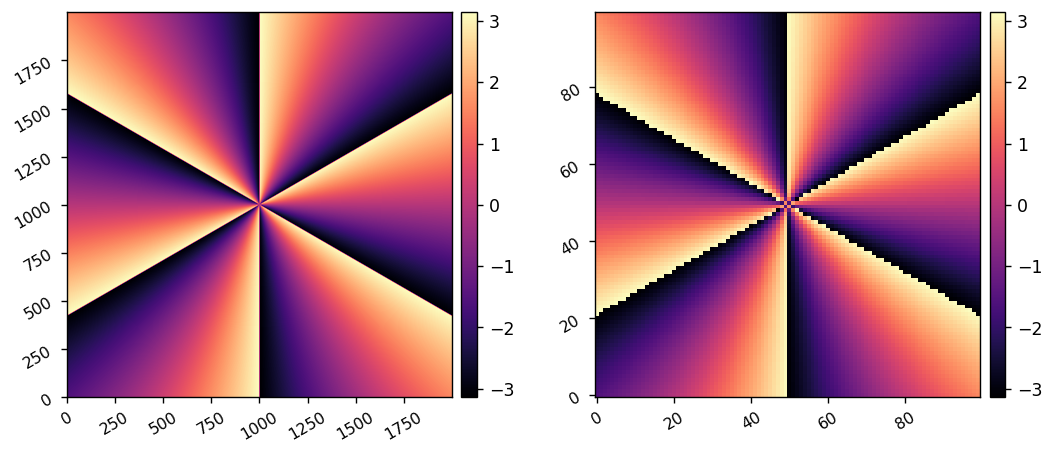

In [3]:
reload(jscoob)
WFE = jscoob.generate_wfe(diam=model.pupil_diam, distance=50*u.mm, 
                          amp_rms=0.02*u.nm, amp_index=3.2,
                          opd_rms=10*u.nm, opd_index=3.2,
                          npix=model.npix, oversample=model.oversample,)
model.WFE = WFE

imshow2(ensure_np_array(jnp.abs(WFE)), ensure_np_array(jnp.angle(WFE))/(2*np.pi)*model.wavelength.to_value(u.m), 
        'Amplitude Errors', 'OPD Errors',
        npix=model.npix,
        vmin1=0.97)

VC = jscoob.make_vortex_phase_mask(model.focal_grid_pol, charge=6, 
#                                    singularity=20*u.um, 
                                   focal_length=500*u.mm, pupil_diam=9.7*u.mm, wavelength=632.8*u.nm)

imshow2(np.angle(jscoob.ensure_np_array(VC)), np.angle(ensure_np_array(jscoob.pad_or_crop(VC, 100))))


In [118]:
model.reset_dm()

2023-09-22 09:34:56.014262: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


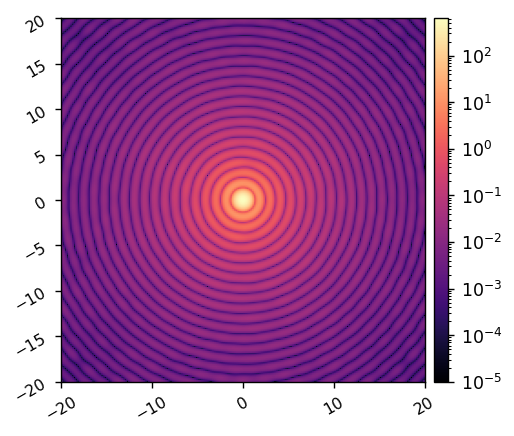

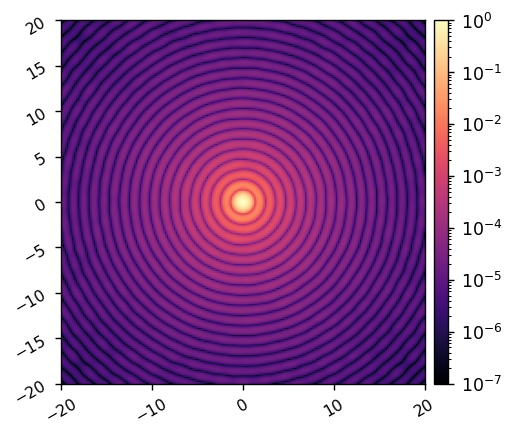

2023-09-22 09:34:59.292245: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-09-22 09:34:59.313317: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


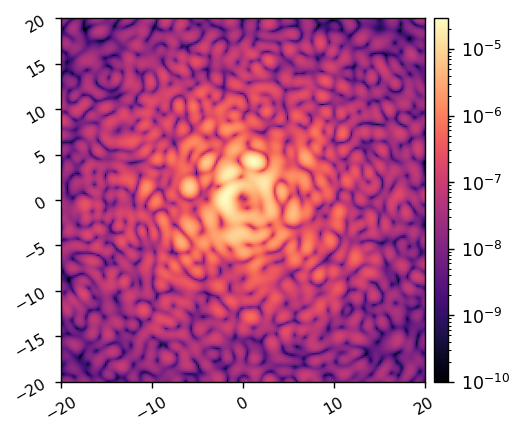

In [4]:
model.FPM = None
ref_unocc_psf = model.snap(plot=True, vmin=1e-5)
model.Imax_ref = ref_unocc_psf.max()
ni_psf = model.snap(plot=True, vmin=1e-7)

model.FPM = VC
image = model.snap(plot=True, vmin=1e-10)

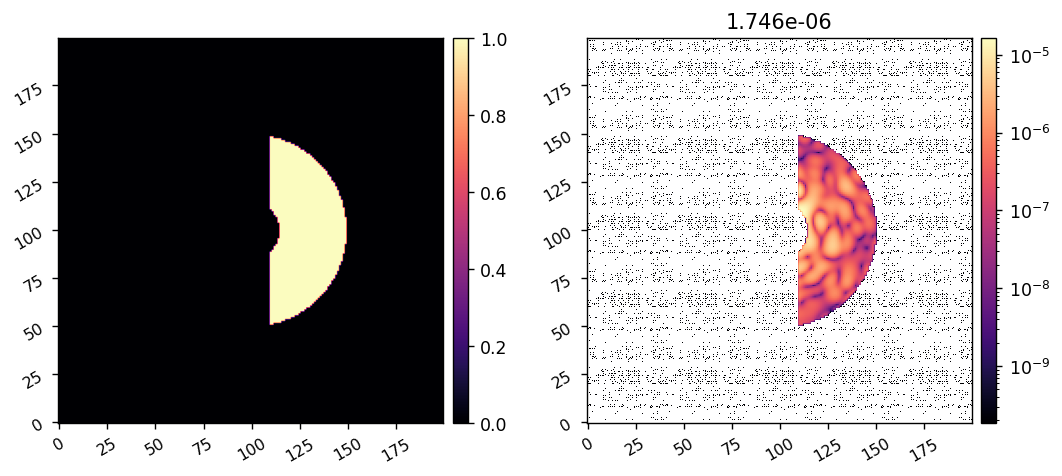

In [13]:
control_mask = (model.im_grid_pol[0] > 3)*(model.im_grid_pol[0] < 10)*(model.im_grid_car[0]>2)
rms_con = jnp.sqrt(jnp.mean(image[control_mask]**2))
imshow2(ensure_np_array(control_mask), ensure_np_array(control_mask*image), None, f'{rms_con:.3e}', lognorm2=True)

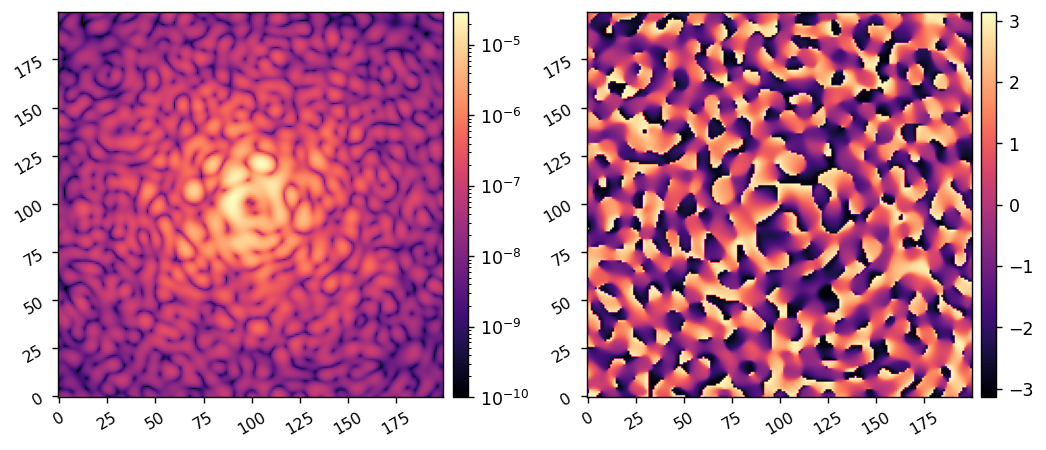

In [6]:
E_ab = model.propagate()
imshow2(ensure_np_array(jnp.abs(E_ab)**2), ensure_np_array(jnp.angle(E_ab)), lognorm1=True, vmin1=1e-10)

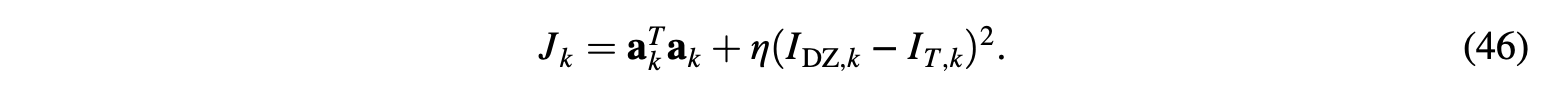

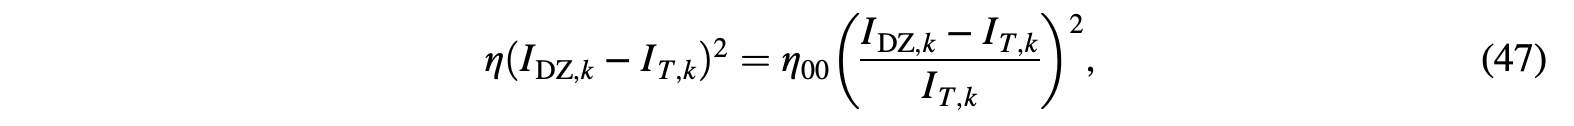

In [30]:
# def cost_fun(acts, I_tar_ratio=1/2, eta_00=1):
#     E_ab = compute_E_ab(model, acts)
#     E_DZ = E_ab[control_mask]
#     I_DZ = jnp.abs(E_DZ.conj().dot(E_DZ))
#     I_tar = I_tar_ratio * I_DZ
#     J = acts.T.dot(acts) + eta_00 * ((I_DZ - I_tar)/I_tar)**2
#     return J

def cost_fun(acts, E_ab, I_tar_ratio=1/2, eta_00=1,):
    '''
    acts: the actuator vector we want to find an optimal solution for
    I_tar_ratio: ratio for the desired target irradiance based on current integrated irradiance
    eta_00: parameter that Scott understands more
    E_ab: current electric-field estimate
    '''
    E_DM = compute_E_DM(acts)
    E_tot = E_DM + E_ab
    I_DZ = jnp.abs(E_DZ.conj().dot(E_DZ))
    I_tar = I_tar_ratio * I_DZ
    J = acts.T.dot(acts) + eta_00 * ((I_DZ - I_tar)/I_tar)**2
    return J

In [32]:
def compute_E_DM(model, acts):
#     E0 = model.propagate()
    model.add_dm(acts)
#     E_DM = (model.propagate() - E0)/(amp_acts)
    E_DM = model.propagate()
    return E_DM

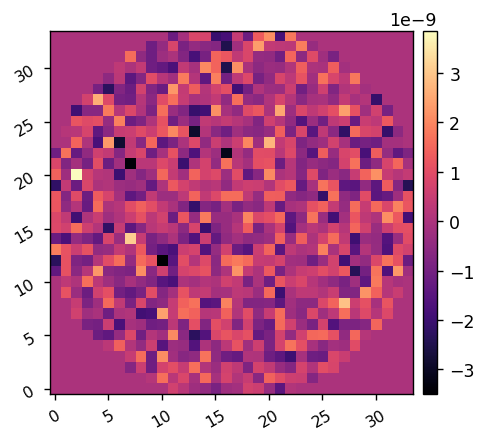

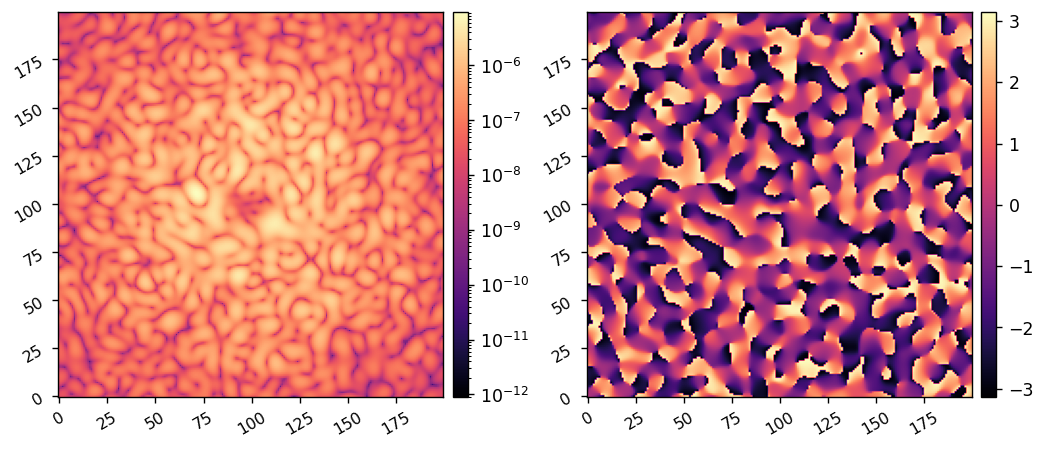

In [28]:
acts = np.random.randn(952)*1e-9
imshow1(ensure_np_array(model.DM.map_actuators_to_command(acts)))

E_DM = ensure_np_array(compute_E_DM(model, acts))
imshow2(np.abs(E_DM)**2, np.angle(E_DM), lognorm1=True)

In [17]:
value_and_grad_fun = jax.value_and_grad(cost)
del_acts_0 = jnp.zeros()

TypeError: minimize() missing 1 required positional argument: 'x0'

In [ ]:
minimize(cost_fun, 
         del_acts_0, 
         jac=True,
         method='BFGS', 
         tol=1e-3,
         options={'disp':True},
        )

In [16]:

jax.value_and_grad(cost_fun, argnums=0)(model.DM.actuators)

2023-09-20 15:16:34.121008: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


(Array(1., dtype=float64),
 Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0